In [1]:
from IPython.display import clear_output

!wget -O event_log.csv https://www.dropbox.com/scl/fi/fhi227vsf7txmbblrpg0t/IT-Incident-Log.csv?rlkey=tck3ikxyabpzxsdm4n74woa25&dl=1

clear_output()
print("Log loaded.")

Log loaded.


In [2]:
!pip install mpvis
!pip install pm4py

clear_output()
print("Packages installed.")

Packages installed.


In [3]:
import mpvis
from mpvis import mddrt
from mpvis import mpdfg
import pm4py
import pandas as pd
from datetime import datetime, timedelta
from IPython.display import SVG, display
clear_output()

In [4]:
event_log = pd.read_csv('event_log.csv', sep = ',')

log_format = {'case:concept:name': 'number',
              'concept:name': 'incident_state',
              'time:timestamp': 'sys_updated_at',
              'start_timestamp': '',
              'org:resource': 'sys_updated_by',
              'cost:total': ''}

event_log = mpvis.log_formatter(event_log.copy(), log_format)

/usr/local/lib/python3.11/dist-packages/mpvis/log_formatter.py:41: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  log["time:timestamp"] = pd.to_datetime(log["time:timestamp"], utc=True, format=timestamp_format)
/usr/local/lib/python3.11/dist-packages/mpvis/log_formatter.py:42: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  log["start_timestamp"] = pd.to_datetime(log["start_timestamp"], utc=True, format=timestamp_format)


In [5]:
print("Case count: " + str(len(set(event_log['case:concept:name']))))
print("Variant count: " + str(len(pm4py.stats.get_variants(event_log.copy()))))
print("Event count: " + str(len(event_log['case:concept:name'])))
print("Activity count: " + str(len(set(event_log['concept:name']))))

Case count: 24918
Variant count: 2079
Event count: 141712
Activity count: 9


In [6]:
mpdfg_discovery_start = datetime.now()

dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(event_log.copy())

mpdfg_discovery_end = datetime.now()

print("MP-DFG discovery time: " + str((mpdfg_discovery_end - mpdfg_discovery_start).total_seconds()) + " seconds.")

MP-DFG discovery time: 37.828102 seconds.


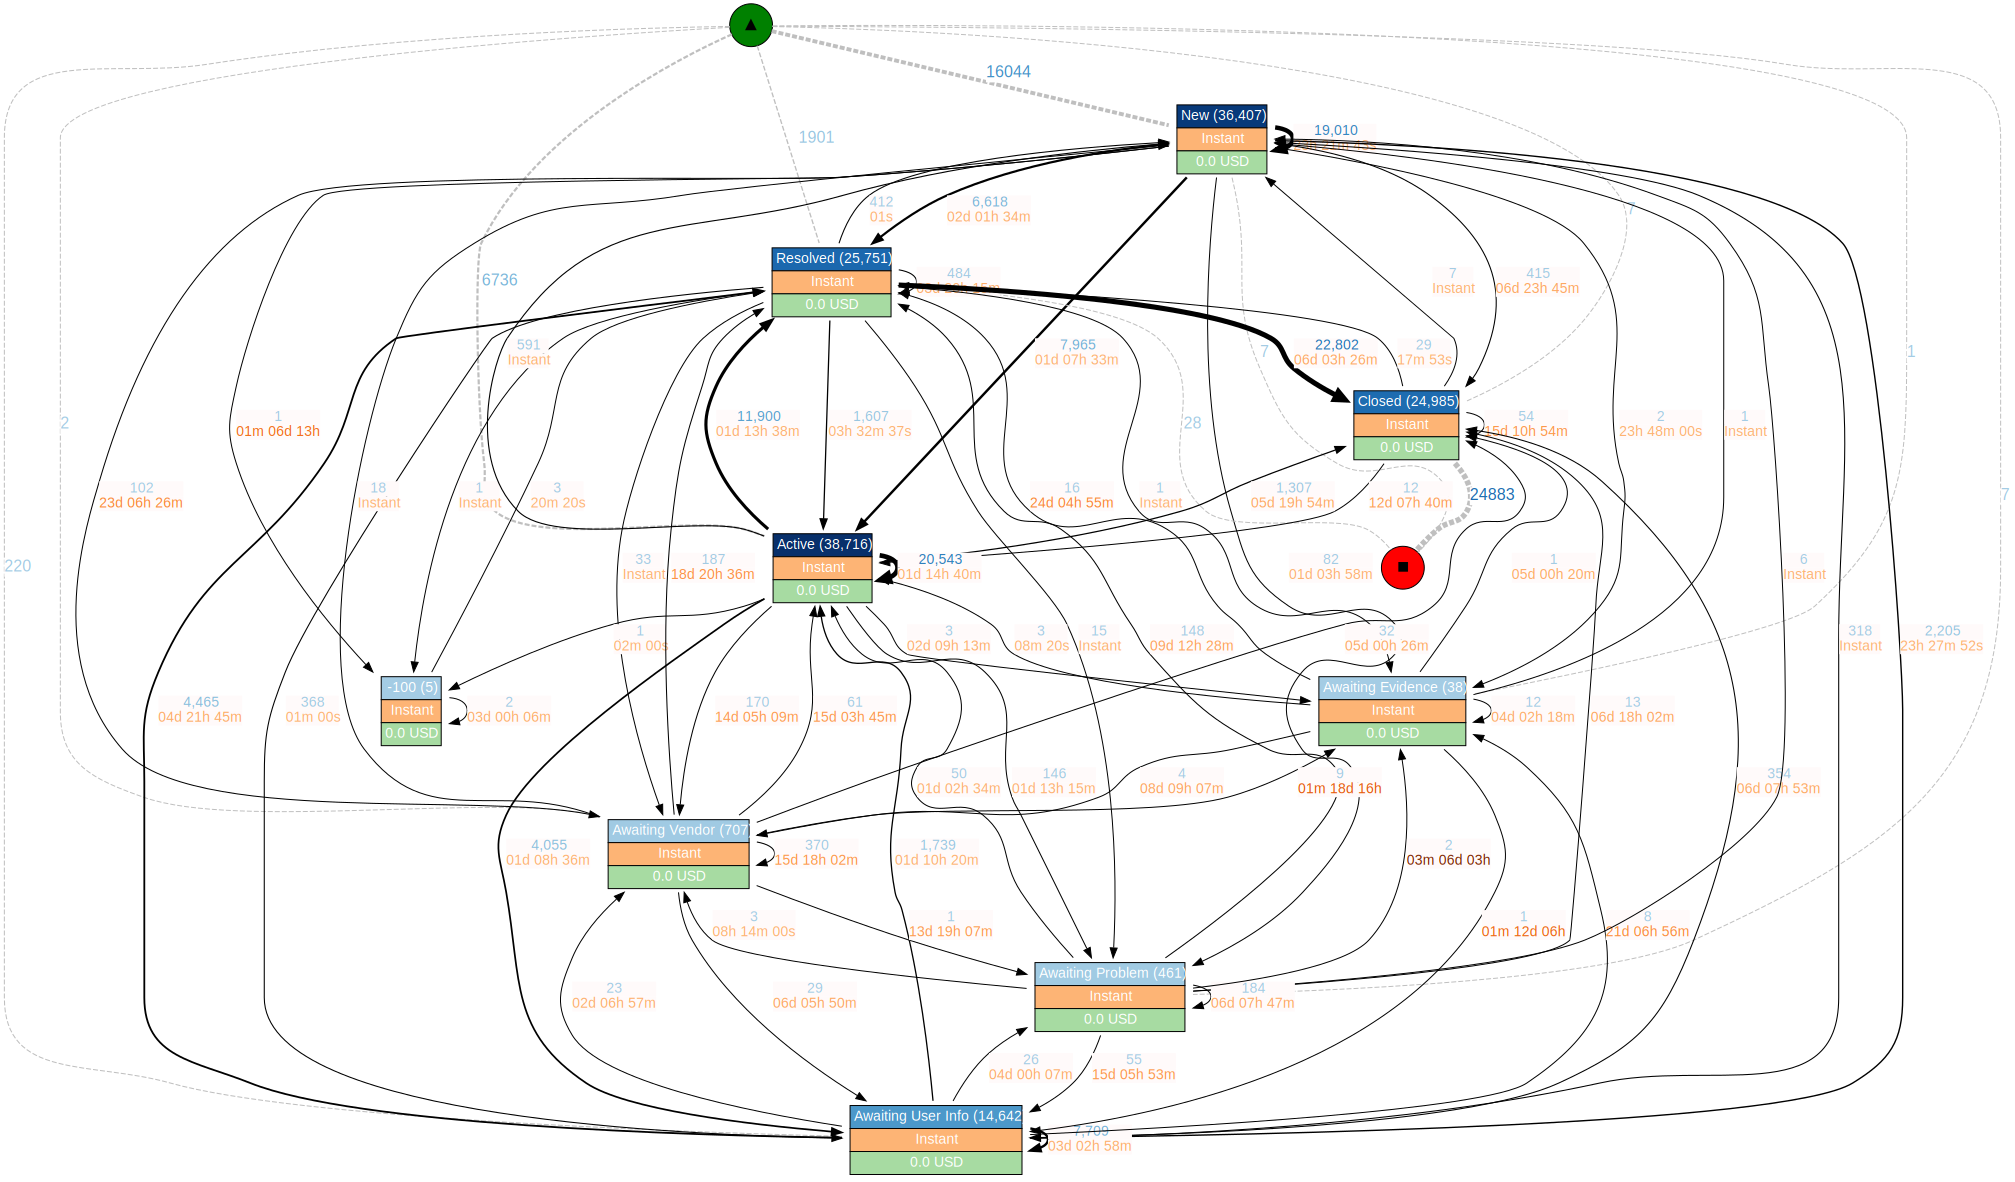

MP-DFG visualization time: 0.254624 seconds.


In [7]:
mpdfg_visualization_start = datetime.now()

mpdfg.view_multi_perspective_dfg(dfg, start_activities, end_activities)

mpdfg_visualization_end = datetime.now()

print("MP-DFG visualization time: " + str((mpdfg_visualization_end - mpdfg_visualization_start).total_seconds()) + " seconds.")

In [8]:
mddrt_discovery_start = datetime.now()

drt = mddrt.discover_multi_dimensional_drt(event_log.copy())

mddrt_discovery_end = datetime.now()

print("MD-DRT discovery time: " + str((mddrt_discovery_end - mddrt_discovery_start).total_seconds()) + " seconds.")

Calculating log mandatory activities: 


100%|██████████| 24918/24918 [06:34<00:00, 63.14it/s]


Calculating log metrics: 


100%|██████████| 24918/24918 [06:46<00:00, 61.31it/s]


Building Tree Cases:


100%|██████████| 24918/24918 [02:35<00:00, 160.33it/s]


Building Tree Graph:


100%|██████████| 24918/24918 [00:02<00:00, 8858.84it/s] 


MD-DRT discovery time: 960.080168 seconds.


In [9]:
mddrt_visualization_start = datetime.now()

mddrt.view_multi_dimensional_drt(drt)

mddrt_visualization_end = datetime.now()

print("MD-DRT visualization time: " + str((mddrt_visualization_end - mddrt_visualization_start).total_seconds()) + " seconds.")

Output hidden; open in https://colab.research.google.com to view.

In [10]:
print("MP-DFG discovery time: " + str((mpdfg_discovery_end - mpdfg_discovery_start).total_seconds()) + " seconds.")
print("MP-DFG visualization time: " + str((mpdfg_visualization_end - mpdfg_visualization_start).total_seconds()) + " seconds.")
print("MD-DRT discovery time: " + str((mddrt_discovery_end - mddrt_discovery_start).total_seconds()) + " seconds.")
print("MD-DRT visualization time: " + str((mddrt_visualization_end - mddrt_visualization_start).total_seconds()) + " seconds.")

MP-DFG discovery time: 37.828102 seconds.
MP-DFG visualization time: 0.254624 seconds.
MD-DRT discovery time: 960.080168 seconds.
MD-DRT visualization time: 135.863328 seconds.


In [11]:
# A copy of the original log is used to allow comparing the processed and original logs
processed_log = event_log.copy()

In [12]:
# The activities of the original log differentiate between different 'Awaiting' activity types (e.g., 'Awaiting Problem')
# To reduce the number of activities, 'Awaiting' transitions are renamed to a unique name
processed_log['concept:name'] = processed_log['concept:name'].str.split(' ').str[0]

print("Activity count before: " + str(len(set(event_log['concept:name']))))
print("Activity count after: " + str(len(set(processed_log['concept:name']))))

Activity count before: 9
Activity count after: 6


In [13]:
# There is an activity named '-100' that occurs 5 times, which seems to be an input error
# Cases containing this activities are removed, as their inclusion increments the complexity of the process models without providing additional insights
processed_log = pm4py.filter_event_attribute_values(processed_log, 'concept:name', ['-100'], level = 'case', retain = False)

# Moreover, the original log contains some cases that seem to be incomplete (e.g., they do not start or end with a valid activity)
# Only cases that start with 'New' and that end with 'Closed' will be considered
processed_log = pm4py.filter_start_activities(processed_log, ['New'])
processed_log = pm4py.filter_end_activities(processed_log, ['Closed'])

# A minimal offset is given to the start and end activities since there are some cases where other activities have the same timestamp
processed_log['start_timestamp'] = processed_log['start_timestamp'].where(processed_log['concept:name'].ne('New'), processed_log['start_timestamp'] - timedelta(microseconds = 1))
processed_log['time:timestamp'] = processed_log['time:timestamp'].where(processed_log['concept:name'].ne('New'), processed_log['time:timestamp'] - timedelta(microseconds = 1))
processed_log['start_timestamp'] = processed_log['start_timestamp'].where(processed_log['concept:name'].ne('Closed'), processed_log['start_timestamp'] + timedelta(microseconds = 1))
processed_log['time:timestamp'] = processed_log['time:timestamp'].where(processed_log['concept:name'].ne('Closed'), processed_log['time:timestamp'] + timedelta(microseconds = 1))

print("Case count before: " + str(len(set(event_log['case:concept:name']))))
print("Case count after: " + str(len(set(processed_log['case:concept:name']))))

Case count before: 24918
Case count after: 16395


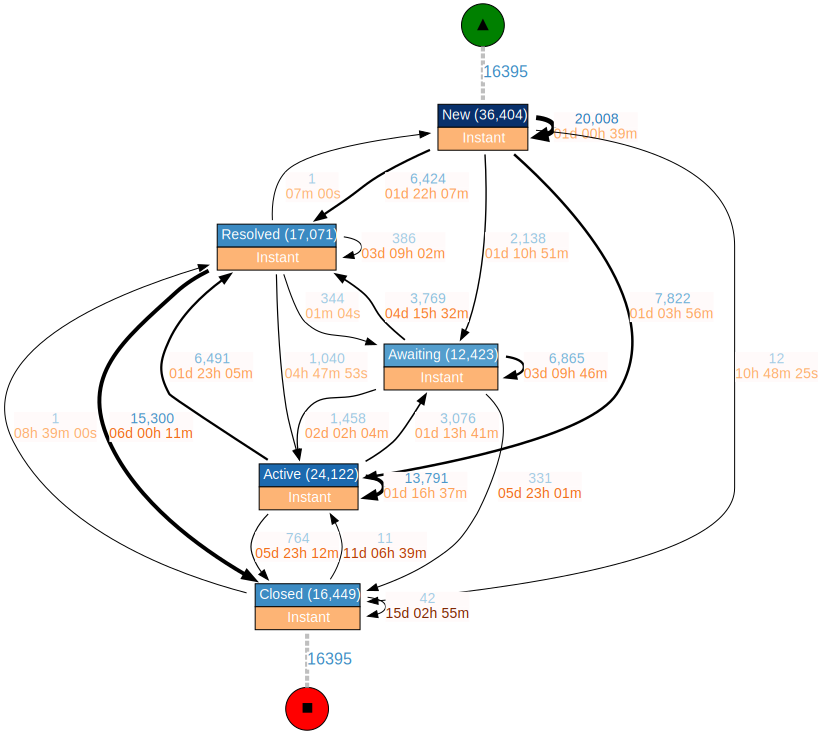

In [14]:
dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(processed_log.copy())

mpdfg.save_vis_multi_perspective_dfg(dfg, start_activities, end_activities, file_name = 'dfg_processed_log_100_100', format = 'svg', visualize_cost = False)
display(SVG(filename = 'dfg_processed_log_100_100.svg'))

In [15]:
# By activating the 'group_activities' flag, linear paths are grouped
drt = mddrt.discover_multi_dimensional_drt(processed_log.copy(), group_activities = True, show_names = True)
mddrt.save_vis_multi_dimensional_drt(drt, file_path = 'drt_processed_log_autogroup', visualize_cost = False)
display(SVG(filename = 'drt_processed_log_autogroup.svg'))

Output hidden; open in https://colab.research.google.com to view.